# Estimating how active actors will be

In this post, we will try to modelize and forecast how many movies we can expect actors to appear in in the future based on their past activity. This is a problem that bears many similarities with marketing topics such as customer analysis, and can be viewed as a Customer Lifetime Value problem. The approach we will present here differs from time series in that we do not really look associate movies with time units with attention, but rather look at aggregate numbers of movies during time ranges to fit probabilistic models.

## 1. Load Data

First, let us install all the packages required for this project. We will mainly be using the package <a href ='https://lifetimes.readthedocs.io/en/latest/index.html'>lifetimes</a>, which has most of the underlying maths already implemented.

In [3]:
! pip install lifetimes

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifetimes import ParetoNBDFitter
%matplotlib inline

In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import ks_2samp

The data we will be using is from IMDB, the code below does loads, unzips and reads the three tables we will need here.

In [7]:
! wget "https://datasets.imdbws.com/title.principals.tsv.gz"
! wget "https://datasets.imdbws.com/title.basics.tsv.gz"
! wget "https://datasets.imdbws.com/name.basics.tsv.gz"

--2019-06-20 02:45:21--  https://datasets.imdbws.com/title.principals.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 13.249.87.10, 13.249.87.86, 13.249.87.129, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|13.249.87.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 288331422 (275M) [binary/octet-stream]
Saving to: ‘title.principals.tsv.gz’

title.principals.ts 100%[===================>] 274.97M  48.6MB/s    in 5.8s    

2019-06-20 02:45:27 (47.5 MB/s) - ‘title.principals.tsv.gz’ saved [288331422/288331422]

--2019-06-20 02:45:28--  https://datasets.imdbws.com/title.basics.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 13.249.87.10, 13.249.87.86, 13.249.87.129, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|13.249.87.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106393375 (101M) [binary/octet-stream]
Saving to: ‘title.basics.tsv.gz’

title.basics.tsv.gz 100%[===============

In [0]:
! gunzip title.principals.tsv.gz
! gunzip title.basics.tsv.gz
! gunzip name.basics.tsv.gz

In [0]:
cast = pd.read_csv('title.principals.tsv', sep='\t', na_values = "\\N", keep_default_na = False, 
                   usecols = ['tconst','ordering','nconst','category','job'],
                   dtype = {'tconst': str, 'ordering': 'Int64', 'nconst': str, 'category': str, 'job': str})
titles = pd.read_csv('title.basics.tsv', sep='\t', na_values = "\\N", keep_default_na = False,
                     usecols = ['tconst','primaryTitle','startYear','titleType'],
                    dtype = {'tconst': str, 'primaryTitle': str, 'startYear': 'Int64','titleType':str})
names = pd.read_csv('name.basics.tsv', sep='\t', na_values = "\\N", keep_default_na = False,
                    usecols = ['nconst','primaryName','birthYear','deathYear'],
                   dtype = {'nconst': str, 'primaryName': str, 'birthYear': 'Int64', 'deathYear': 'Int64'})

In [0]:
startYear = 1950
endYear = 1960

In [11]:
cast.head()

,tconst,ordering,nconst,category,job
0,tt0000001,1,nm1588970,self,NaN
1,tt0000001,2,nm0005690,director,NaN
2,tt0000001,3,nm0374658,cinematographer,director of photography
3,tt0000002,1,nm0721526,director,NaN
4,tt0000002,2,nm1335271,composer,NaN


In [12]:
movie_titles = titles[titles.titleType == 'movie']
titles.head()

,tconst,titleType,primaryTitle,startYear
0,tt0000001,short,Carmencita,1894
1,tt0000002,short,Le clown et ses chiens,1892
2,tt0000003,short,Pauvre Pierrot,1892
3,tt0000004,short,Un bon bock,1892
4,tt0000005,short,Blacksmith Scene,1893


In [13]:
names["alive"] = names.deathYear.isnull()
names.head()

,nconst,primaryName,birthYear,deathYear,alive
0,nm0000001,Fred Astaire,1899,1987,False
1,nm0000002,Lauren Bacall,1924,2014,False
2,nm0000003,Brigitte Bardot,1934,NaN,True
3,nm0000004,John Belushi,1949,1982,False
4,nm0000005,Ingmar Bergman,1918,2007,False


In [0]:
classic_names = names[(names.birthYear<=startYear-10) & ((names.deathYear>=endYear) | (names.alive == True))]

In [15]:
classic_names.head()

,nconst,primaryName,birthYear,deathYear,alive
0,nm0000001,Fred Astaire,1899,1987,False
1,nm0000002,Lauren Bacall,1924,2014,False
2,nm0000003,Brigitte Bardot,1934,NaN,True
4,nm0000005,Ingmar Bergman,1918,2007,False
5,nm0000006,Ingrid Bergman,1915,1982,False


In [0]:
actors = ["Lauren Bacall", "Cary Grant", "Ingrid Bergman", "James Stewart", "Elizabeth Taylor", "Gary Cooper",
         "Clark Gable", "Katharine Hepburn"]

In [0]:
names_actors = names[names.primaryName.isin(actors)].head(len(actors))

In [0]:
names_actors = names_actors[names_actors.deathYear >= endYear]

In [19]:
names_actors

,nconst,primaryName,birthYear,deathYear,alive
1,nm0000002,Lauren Bacall,1924,2014,False
5,nm0000006,Ingrid Bergman,1915,1982,False
10,nm0000011,Gary Cooper,1901,1961,False
21,nm0000022,Clark Gable,1901,1960,False
25,nm0000026,Cary Grant,1904,1986,False
30,nm0000031,Katharine Hepburn,1907,2003,False
70,nm0000071,James Stewart,1908,1997,False
71,nm0000072,Elizabeth Taylor,1932,2011,False


In [0]:
classic_cast_actors = pd.merge(classic_names, cast, on = 'nconst')

In [0]:
movie_actors = pd.merge(classic_cast_actors, movie_titles, on = 'tconst')

In [0]:
movie_list = movie_actors[['primaryName','birthYear','deathYear','category','primaryTitle','startYear']]

In [0]:
movie_list = movie_list[movie_list.category.isin(['actor','actress'])]

In [24]:
movie_list.head()

,primaryName,birthYear,deathYear,category,primaryTitle,startYear
0,Fred Astaire,1899,1987,actor,The Gay Divorcee,1934
1,Ginger Rogers,1911,1995,actress,The Gay Divorcee,1934
2,Edward Everett Horton,1886,1970,actor,The Gay Divorcee,1934
7,Fred Astaire,1899,1987,actor,Roberta,1935
8,Randolph Scott,1898,1987,actor,Roberta,1935


In [0]:
active_actors = movie_list[movie_list.startYear > startYear - 5].groupby("primaryName").agg({"startYear":'min'}).reset_index()
active_actors_list = active_actors[active_actors.startYear < startYear]
actors_list = active_actors_list["primaryName"]

In [0]:
movie_list = movie_list[movie_list.primaryName.isin(actors_list)]
movie_list_observed = movie_list[movie_list.startYear.isin(range(startYear,endYear))]
movie_list_unobserved = movie_list[movie_list.startYear.isin(range(endYear,endYear+10))]

In [0]:
movie_counts = movie_list_observed.groupby(['primaryName','startYear']).agg({'primaryTitle': 'count'}).reset_index().rename(columns = {'primaryTitle':'numberMovies'})
movie_counts_validation = movie_list_unobserved.groupby(['primaryName','startYear']).agg({'primaryTitle': 'count'}).reset_index().rename(columns = {'primaryTitle':'numberMovies'})

In [28]:
movie_counts.groupby('primaryName').agg({'numberMovies':'sum'}).head()

,numberMovies
primaryName,
A.E. Matthews,6
Abbas Fares,8
Abdel Aziz Mahmoud,8
Abdel Fatah Al Kasri,13
Abdulsalam El-Nabulsi,37


In [29]:
movie_counts.head()

,primaryName,startYear,numberMovies
0,A.E. Matthews,1951,1
1,A.E. Matthews,1952,3
2,A.E. Matthews,1954,1
3,A.E. Matthews,1956,1
4,Abbas Fares,1951,3


In [0]:
def plot_history_actor(ax, actor_name, max_value):
  actor_history = movie_counts[movie_counts.primaryName == actor_name]
  ax.bar(actor_history.startYear, actor_history.numberMovies, color = 'firebrick')
  ax.set_xticks([i for i in range(1950,1960)])
  ax.set_yticks(np.linspace(0,max_value,max_value+1))
  ax.set_title(actor_name)
  ax.set_facecolor("linen")
  ax.grid(color = 'white', linewidth = 1.5)
  ax.set_axisbelow(True)

def plot_history_actors(actors):
  n = len(actors)
  k = round(n/3+0.5)
  max_value = movie_counts[movie_counts.primaryName.isin(actors)].numberMovies.max()
  fig, axes = plt.subplots(k,3, figsize = (15,2*k))
  for ax, actor_name in zip(axes.ravel(), actors):
    plot_history_actor(ax, actor_name, max_value)
  for i in range(n,k*3):
    fig.delaxes(axes.ravel()[i])
  fig.suptitle("Number of movies made each year", y = 1.1, fontsize = 20)
  fig.tight_layout()

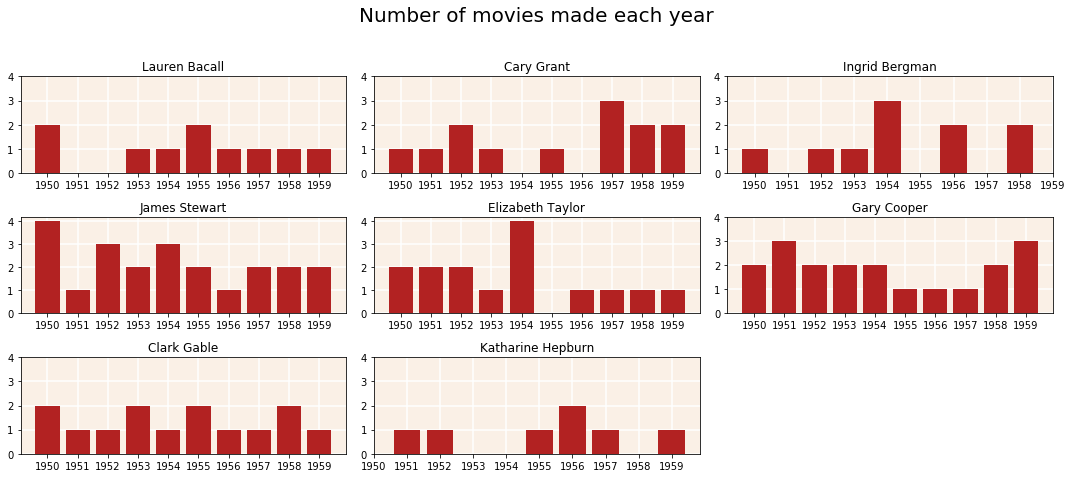

In [31]:
plot_history_actors(actors)

In [0]:
lambda_actors = movie_counts.groupby("primaryName").agg({"numberMovies" : "sum"}).reset_index()
lambda_actors["lambda"] = lambda_actors.numberMovies/(endYear - startYear)
lambda_actors = lambda_actors.merge(actors_list, on = "primaryName", how = "right").fillna(0)
lambda_actors["numberMovies"] = lambda_actors.numberMovies.astype(int)

In [33]:
lambda_actors.head()

,primaryName,numberMovies,lambda
0,A.E. Matthews,6,0.6
1,Abbas Fares,8,0.8
2,Abdel Aziz Mahmoud,8,0.8
3,Abdel Fatah Al Kasri,13,1.3
4,Abdulsalam El-Nabulsi,37,3.7


In [0]:
def probability(lambda_param, t, k):
  return np.exp(-lambda_param*t)*(lambda_param*t)**k/np.math.factorial(k)

In [0]:
def plot_probability_actor(ax, actor_name, t):
  lambda_param = lambda_actors[lambda_actors.primaryName == actor_name]["lambda"].iloc[0]
  k_list = np.linspace(0,40,41)
  probability_list = np.array([probability(lambda_param, t, k) for k in k_list])
  ax.plot(k_list, probability_list, color = 'firebrick')
  ax.fill_between(k_list, probability_list,  color = 'firebrick', alpha = 0.5)
  ax.axvline(x=lambda_param*t, color = 'k', linestyle = '--')
  ax.set_title(actor_name)
  ax.set_facecolor("linen")
  ax.grid(color = 'white', linewidth = 1.5)
  ax.set_axisbelow(True)

def plot_probability_actors(actors, t):
  n = len(actors)
  k = round(n/3+0.5)
  fig, axes = plt.subplots(k,3, figsize = (15,2*k))
  for ax, actor_name in zip(axes.ravel(), actors):
    plot_probability_actor(ax, actor_name, t)
  for i in range(n,k*3):
    fig.delaxes(axes.ravel()[i])
  fig.suptitle("Fitted probability distribution for t = " + str(t)+ " years", y = 1.1, fontsize = 20)
  fig.tight_layout()

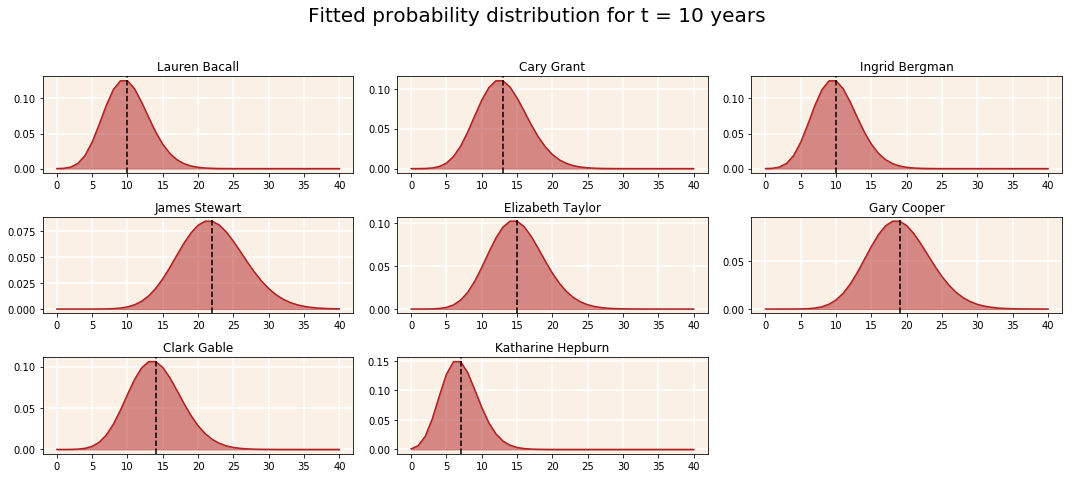

In [36]:
plot_probability_actors(actors, 10)

In [0]:
def cdf(lambda_param, t, n):
  cdf = 0
  for i in range(n):
    cdf += probability(lambda_param, t, i)
  return cdf

In [0]:
def plot_cdf_actor(ax, actor_name, t):
  lambda_param = lambda_actors[lambda_actors.primaryName == actor_name]["lambda"].iloc[0]
  n_list = np.linspace(0,40,41, dtype = int)
  probability_list = np.array([1-cdf(lambda_param, t, n) for n in n_list])
  ax.bar(n_list, probability_list, color = 'firebrick')
  ax.set_yticks(np.linspace(0,1,5))
  ax.set_title(actor_name)
  ax.set_facecolor("linen")
  ax.grid(color = 'white', linewidth = 1.5)
  ax.set_axisbelow(True)

def plot_cdf_actors(actors, t):
  n = len(actors)
  k = round(n/3+0.5)
  fig, axes = plt.subplots(k,3, figsize = (15,2*k))
  for ax, actor_name in zip(axes.ravel(), actors):
    plot_cdf_actor(ax, actor_name, t)
  for i in range(n,k*3):
    fig.delaxes(axes.ravel()[i])
  fig.suptitle("Probability of appearing in more than n movies in t = "+ str(t) +" years", y = 1.1, fontsize = 20)
  fig.tight_layout()

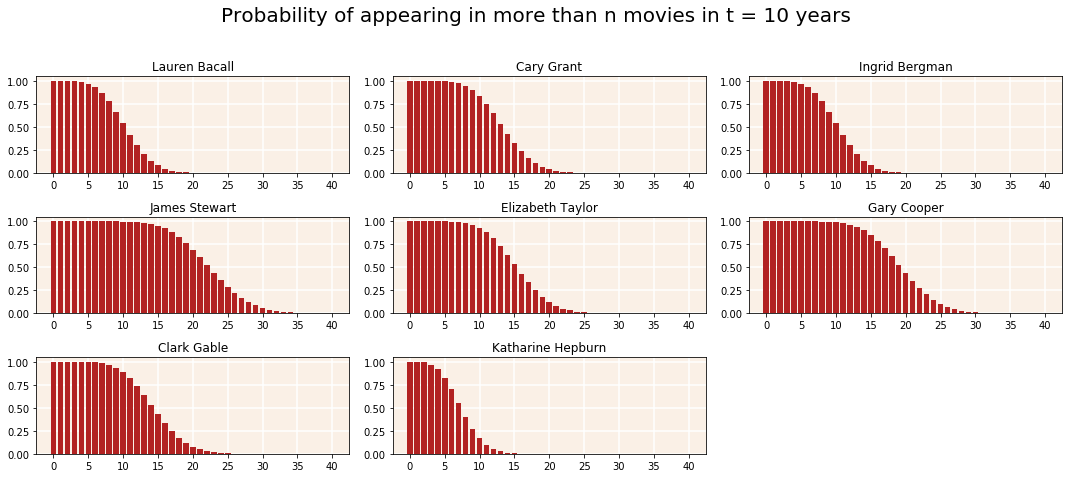

In [39]:
plot_cdf_actors(actors, 10)

In [0]:
def waiting_time(lambda_param, t):
  return np.exp(-lambda_param*(t-1)) - np.exp(-lambda_param*t)

In [0]:
def plot_waiting_time_actor(ax, actor_name):
  lambda_param = lambda_actors[lambda_actors.primaryName == actor_name]["lambda"].iloc[0]
  t_list = np.linspace(1,5,5, dtype = int)
  waiting_time_list = np.array([waiting_time(lambda_param, t) for t in t_list])
  x_axis = [str(t-1) + "-" + str(t) + " y" for t in t_list]
  ax.bar(x_axis, waiting_time_list, color = 'firebrick')
  ax.set_yticks(np.linspace(0,1,5))
  ax.set_title(actor_name)
  ax.set_facecolor("linen")
  ax.grid(axis = 'y', color = 'white', linewidth = 1.5)
  ax.set_axisbelow(True)

def plot_waiting_time_actors(actors):
  n = len(actors)
  k = round(n/3+0.5)
  fig, axes = plt.subplots(k,3, figsize = (15,2*k))
  for ax, actor_name in zip(axes.ravel(), actors):
    plot_waiting_time_actor(ax, actor_name)
  for i in range(n,k*3):
    fig.delaxes(axes.ravel()[i])
  fig.suptitle("Probability distribution of waiting time between two movies in years", y = 1.1, fontsize = 20)
  fig.tight_layout()

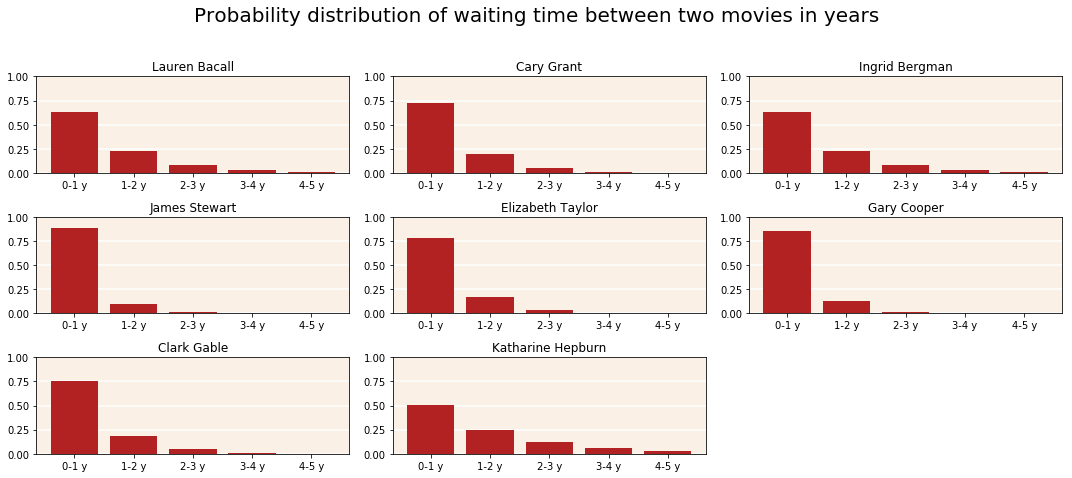

In [42]:
plot_waiting_time_actors(actors)

In [43]:
movie_counts_validation.groupby('primaryName').agg({'numberMovies':'sum'}).head()

,numberMovies
primaryName,
Aage Fønss,1
Abbas Fares,4
Abdel Fatah Al Kasri,3
Abdulsalam El-Nabulsi,18
Abdulwareth Asar,2


In [44]:
lambda_actors.head()

,primaryName,numberMovies,lambda
0,A.E. Matthews,6,0.6
1,Abbas Fares,8,0.8
2,Abdel Aziz Mahmoud,8,0.8
3,Abdel Fatah Al Kasri,13,1.3
4,Abdulsalam El-Nabulsi,37,3.7


In [0]:
def compute_prediction(n,t):
  return lambda_actors["lambda"].apply(lambda x: np.exp(-x*t)*(x*t)**n/np.math.factorial(n)).sum()

In [0]:
def compute_predictions(t):
  fig, ax = plt.subplots(figsize=(10, 5))
  x_list = np.linspace(0,50,51)
  prediction_list = np.array([compute_prediction(n,t) for n in x_list])
  ax.bar(x_list, prediction_list)
  ax.set_title("Prediction of the number of movies between 1960 and 1969", y = 1.1)

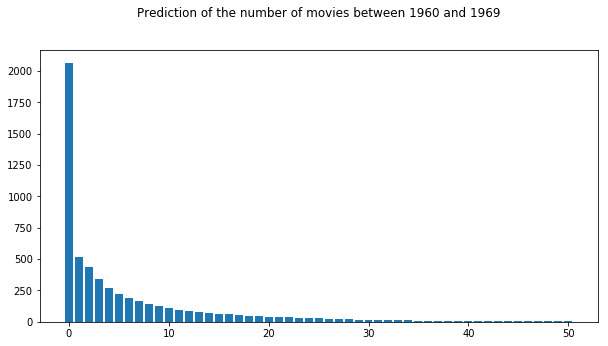

In [47]:
compute_predictions(10)

In [48]:
t = 10
total_prediction = np.sum(lambda_actors["lambda"])*t
print("For this actor sample, we can estimate they will appear in %i movies in the next %i years" % (total_prediction,t))

For this actor sample, we can estimate they will appear in 33607 movies in the next 10 years


In [49]:
real_amount = np.sum(movie_counts_validation["numberMovies"])
print("In reality, these actors appeared in %i movies during between 1960 and 1969" % real_amount)

In reality, these actors appeared in 17010 movies during between 1960 and 1969


In [50]:
movie_counts_validation.head()

,primaryName,startYear,numberMovies
0,Aage Fønss,1968,1
1,Abbas Fares,1968,4
2,Abdel Fatah Al Kasri,1960,2
3,Abdel Fatah Al Kasri,1961,1
4,Abdulsalam El-Nabulsi,1960,5


In [0]:
total_validation = movie_counts_validation.groupby('primaryName').agg({'numberMovies':'sum'}).merge(actors_list, on = "primaryName", how = "right").fillna(0).groupby("numberMovies").agg({"numberMovies":'count'}).rename(columns = {"numberMovies":"count"}).reset_index()
total_validation = total_validation.merge(pd.DataFrame({"numberMovies":np.arange(51)}), how = "right").fillna(0).sort_values(by = "numberMovies")

In [52]:
total_validation.head()

,numberMovies,count
0,0.0,3153.0
1,1.0,746.0
2,2.0,387.0
3,3.0,256.0
4,4.0,163.0


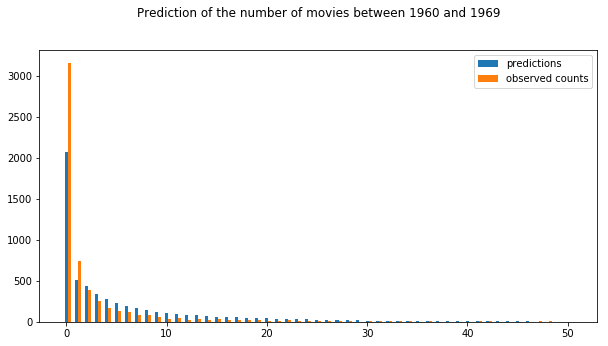

In [53]:
width = 0.3
fig, ax = plt.subplots(figsize=(10, 5))
x_list = np.arange(51)
prediction_list = np.array([compute_prediction(n,t) for n in x_list])
ax.bar(x_list, prediction_list, width, label = "predictions")
ax.set_title("Prediction of the number of movies between 1960 and 1969", y = 1.1)

ax.bar(x_list + width, total_validation["count"], width, label = "observed counts")

ax.legend(loc = "upper right")

In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mean_squared_error(total_validation["count"], prediction_list),mean_absolute_error(total_validation["count"], prediction_list),r2_score(total_validation["count"], prediction_list)

(25809.56819306416, 51.772353660971646, 0.8706540128044938)

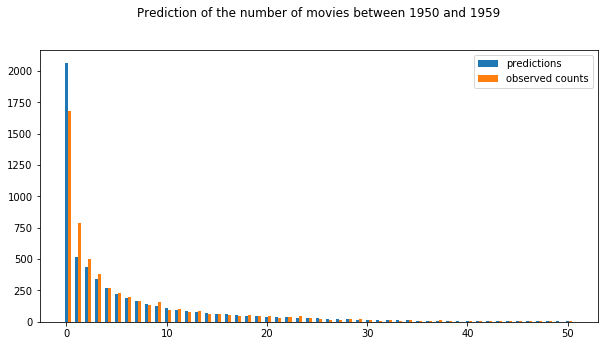

In [55]:
total_training = movie_counts.groupby('primaryName').agg({'numberMovies':'sum'}).merge(actors_list, on = "primaryName", how = "right").fillna(0).groupby("numberMovies").agg({"numberMovies":'count'}).rename(columns = {"numberMovies":"count"}).reset_index()
total_training = total_training.merge(pd.DataFrame({"numberMovies":np.arange(51)}), how = "right").fillna(0).sort_values(by = "numberMovies")

width = 0.3
fig, ax = plt.subplots(figsize=(10, 5))
x_list = np.arange(51)
prediction_list = np.array([compute_prediction(n,t) for n in x_list])
ax.bar(x_list, prediction_list, width, label = "predictions")
ax.set_title("Prediction of the number of movies between 1950 and 1959", y = 1.1)

ax.bar(x_list + width, total_training["count"], width, label = "observed counts")

ax.legend(loc = "upper right")

In [56]:
movie_counts.head()

,primaryName,startYear,numberMovies
0,A.E. Matthews,1951,1
1,A.E. Matthews,1952,3
2,A.E. Matthews,1954,1
3,A.E. Matthews,1956,1
4,Abbas Fares,1951,3


In [0]:
movie_counts_reshape = movie_counts.groupby("primaryName").agg({"numberMovies":'sum', "startYear":'max'}).reset_index().rename(columns = {"startYear":"recency","numberMovies":"frequency"})
movie_counts_reshape = movie_counts_reshape.merge(actors_list, on = "primaryName", how = "right")

In [58]:
movie_counts_reshape.head()

,primaryName,frequency,recency
0,A.E. Matthews,6.0,1956.0
1,Abbas Fares,8.0,1959.0
2,Abdel Aziz Mahmoud,8.0,1954.0
3,Abdel Fatah Al Kasri,13.0,1958.0
4,Abdulsalam El-Nabulsi,37.0,1959.0


In [59]:
movie_counts_reshape["recency"] = movie_counts_reshape.recency - startYear + 1
movie_counts_reshape.fillna(0, inplace = True)
movie_counts_reshape["T"] = endYear-startYear
movie_counts_reshape.head()

,primaryName,frequency,recency,T
0,A.E. Matthews,6.0,7.0,10
1,Abbas Fares,8.0,10.0,10
2,Abdel Aziz Mahmoud,8.0,5.0,10
3,Abdel Fatah Al Kasri,13.0,9.0,10
4,Abdulsalam El-Nabulsi,37.0,10.0,10


In [60]:
pnbd = ParetoNBDFitter(penalizer_coef=0.1)
pnbd.fit(movie_counts_reshape['frequency'], movie_counts_reshape['recency'], movie_counts_reshape['T'])

<lifetimes.ParetoNBDFitter: fitted with 5662 subjects, alpha: 0.77, beta: 36.69, r: 0.52, s: 1.16>

In [61]:
#print(pnbd.summary)
pnbd.params_

r         0.516843
alpha     0.772973
s         1.156463
beta     36.686885
dtype: float64

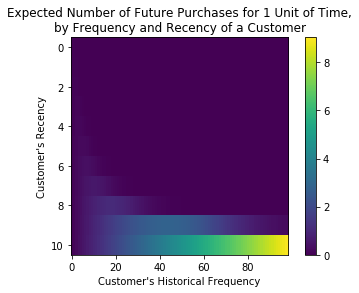

In [62]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(pnbd)

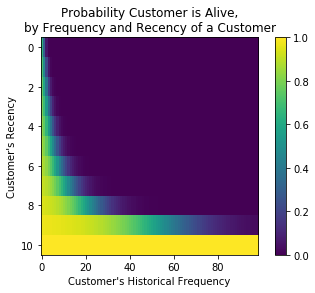

In [63]:
from lifetimes.plotting import plot_probability_alive_matrix, plot_history_alive

plot_probability_alive_matrix(pnbd)

In [64]:
t_future = 10
movie_counts_reshape['predicted_purchases'] = pnbd.conditional_expected_number_of_purchases_up_to_time(t_future, movie_counts_reshape['frequency'], movie_counts_reshape['recency'], movie_counts_reshape['T'])
movie_counts_reshape.sort_values(by='predicted_purchases').tail(5)

,primaryName,frequency,recency,T,predicted_purchases
597,Chhabi Biswas,76.0,10.0,10,63.389739
200,Anjali Devi,77.0,10.0,10,64.218181
1620,Ismail Yassin,78.0,10.0,10,65.046623
3443,Shyama,81.0,10.0,10,67.531948
2812,Nirupa Roy,98.0,10.0,10,81.615455


In [65]:
individual = movie_counts_reshape[movie_counts_reshape.primaryName == "Cary Grant"]
individual

,primaryName,frequency,recency,T,predicted_purchases
549,Cary Grant,13.0,10.0,10,11.197916


In [66]:
pnbd.conditional_probability_of_n_purchases_up_to_time(0, t_future, movie_counts_reshape['frequency'], movie_counts_reshape['recency'], movie_counts_reshape['T'])[:5]

0    0.254684
1    0.035916
2    0.830495
3    0.069254
4    0.007207
dtype: float64

In [67]:
movie_counts[movie_counts.primaryName == "Cary Grant"]

,primaryName,startYear,numberMovies
2306,Cary Grant,1950,1
2307,Cary Grant,1951,1
2308,Cary Grant,1952,2
2309,Cary Grant,1953,1
2310,Cary Grant,1955,1
2311,Cary Grant,1957,3
2312,Cary Grant,1958,2
2313,Cary Grant,1959,2


In [0]:
def plot_p_alive_actor(ax, actor_name):
  history_actor = movie_counts[movie_counts.primaryName == actor_name]
  history_actor.startYear = pd.to_datetime(history_actor.startYear, format='%Y')
  plot_history_alive(pnbd, t_future, history_actor, 'startYear', freq = 'Y', ax = ax)
  ax.set_title(actor_name)

def plot_p_alive_actors(actors):
  n = len(actors)
  k = round(n/3+0.5)
  fig, axes = plt.subplots(k,3, figsize = (15,2*k))
  for ax, actor_name in zip(axes.ravel(), actors):
    plt.sca(ax)
    plot_p_alive_actor(ax, actor_name)
  for i in range(n,k*3):
    fig.delaxes(axes.ravel()[i])
  fig.suptitle("Probability of being active during the training period", y = 1.1, fontsize = 20)
  fig.tight_layout()

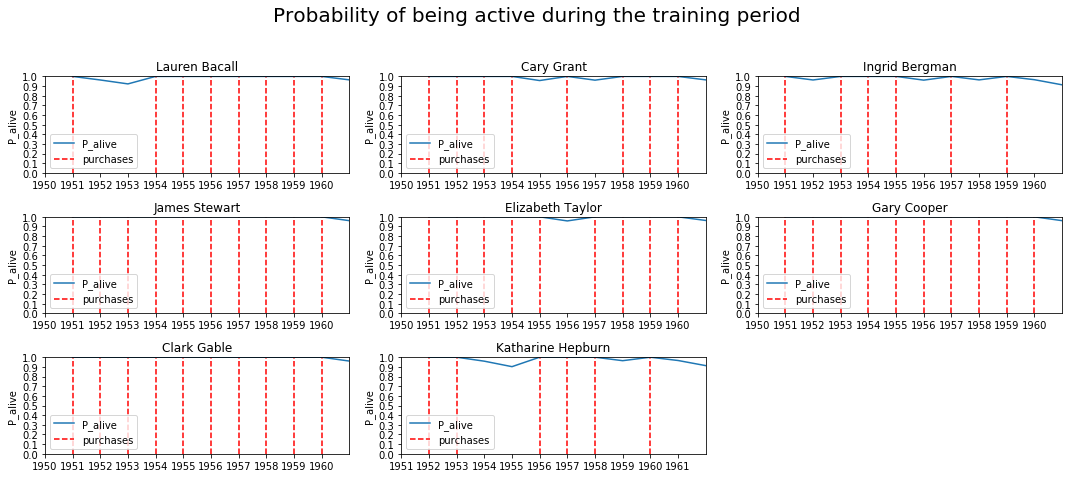

In [69]:
plot_p_alive_actors(actors)

In [70]:
active_actors_list.head()

,primaryName,startYear
0,'Ducky' Louie,1947
6,A.E. Matthews,1949
12,Aage Fønss,1949
17,Aarne Laine,1949
29,Abbas Fares,1946


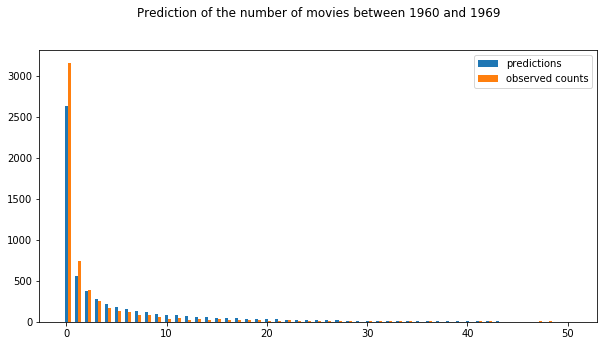

In [71]:
width = 0.3
fig, ax = plt.subplots(figsize=(10, 5))
x_list = np.arange(51)
prediction_list = np.array([pnbd.conditional_probability_of_n_purchases_up_to_time(n, t_future, movie_counts_reshape['frequency'], 
                                                     movie_counts_reshape['recency'], movie_counts_reshape['T']).sum() for n in x_list])
ax.bar(x_list, prediction_list, width, label = "predictions")
ax.set_title("Prediction of the number of movies between 1960 and 1969", y = 1.1)

ax.bar(x_list + width, total_validation["count"], width, label = "observed counts")

ax.legend(loc = "upper right")

In [72]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mean_squared_error(total_validation["count"], prediction_list),mean_absolute_error(total_validation["count"], prediction_list),r2_score(total_validation["count"], prediction_list)

(6584.009787049018, 28.921785128692374, 0.9670038940891856)